# Perception with Graphical Models

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S34_vacuum_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
# %pip install -U -q gtbook

In [3]:
%pip install gtsam-develop

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import gtsam
import pandas as pd

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables
VARIABLES = Variables()

def pretty(obj):
    return gtbook.display.pretty(obj, VARIABLES)

def show(obj, **kwargs):
    return gtbook.display.show(obj, VARIABLES, **kwargs)

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

In [5]:
var = Variables()

In [6]:
Q5 =var.binary("Qupid")

In [7]:
Q5

(0, 2)

In [8]:
var.discrete_series("S",range(3), ["Sad", "Happy", "Excited", "Angry", "Relaxed", "Bored", "Sleepy"])

{0: (5980780305148018688, 7),
 1: (5980780305148018689, 7),
 2: (5980780305148018690, 7)}

In [9]:
# From section 3.2:
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")

# From Section 3.3:
N = 3
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms)
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space)
Z = VARIABLES.discrete_series("Z", range(1, N+1), vacuum.light_levels)

```{index} perception; hidden Markov models
```

> Perception using dynamic Bayes nets is equivalent to inference in hidden Markov models (HMMs).

<img src="Figures3/S34-iRobot_vacuuming_robot-05.jpg" alt="Splash image with deeply contemplative robot" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

```{index} factor graphs
```
Now that we have a solid mathematical framework, in the remainder of this chapter we will tackle perception, decision-making based on this, and learning to improve both. We used the vacuum cleaning robot as an example system that has discrete states, with actions that mediate discrete-time state transitions, and collecting noisy measurements at every step. The key mathematical concept that tied all this together was the language of dynamic Bayes nets. 

In this section we tackle *perception* in this setting: can we, by remembering which actions we took and what measurements we observed, infer what states we were in and are likely to be in now? 
We more formally define what we mean by inference, building on the methods introduced in Section 2.4.
Just as we did there, we will characterize what we know and don't know using probability distributions, leaning into the Bayesian view even more.
However, here we will consider probability distributions over *sequences* of states, rather than just the current state.

To this end, we introduce one of the most important tools used throughout this book: **factor graphs**. Bayes nets are great for *modeling*, but for inferring the state of the robot over time *efficiently* we need a better data structure. 
We first introduce hidden Markov models (HMMs), and highlight their connection with robot localization over time. We then show how to efficiently perform inference by converting an HMM into a factor graph, and performing full posterior inference and MAP estimation in linear time.

```{index} inference
```
## Inference in Bayes Nets

> Inference begets the full posterior or a single maximum a posteriori estimate.

**Inference** is the process of determining knowledge about a set of
variables $\mathcal{X}$ given the known values for another set of variables $\mathcal{Z}$.
In this section we will describe inference when the joint
distribution is specified using a Bayes net, but we will not take
advantage of the specific sparse structure of the network.
Hence, the algorithms
below are completely general, for any (discrete) joint probability
distribution, as long as we can evaluate the joint distribution.

```{index} hidden variables, observations
```
### Full Posterior Inference

> Naive full posterior inference is *easy* but probably expensive.

The simplest kind of inference occurs when we can *partition* the variables into two
sets: the **hidden variables** $\mathcal{X}$ and the **observations**
$\mathcal{Z}$. First, let us recall what a Bayes net looks like in this case.
From Section 3.2, we know that a general Bayes net over any set of variables is defined as a product of conditionals, as in Equation [3.13](#bn_is_product).
Hence in our case we have
\begin{equation}
P(\mathcal{X}, \mathcal{Z}) = \prod_{i=1}P(X_{i}|\Pi_{X_i}) \prod_{j=1}P(Z_{j}|\Pi_{Z_j})
\end{equation}
where there is no restriction on the parent sets $\Pi$, just that the directed graph is acyclic. Of course, we will be most interested here in dynamic Bayes nets as defined previously, but for now what follows applies to generic Bayes nets.

The workhorse in inference is Bayes’ theorem, which we encountered in the perception section of the previous chapter, Section 2.4. 
Let us define $\mathfrak{z}$ as the set of observed *values* for all variables in
$\mathcal{Z}$.
We then are interested, *given* the values $\mathfrak{z}$ for the observed values $\mathcal{Z}$, in calculating the posterior probability distribution $P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$.
To calculate this we apply Bayes’ theorem, but now applied to
*sets* of variables, to obtain an expression for the posterior over the
hidden variables $\mathcal{X}$. Using the "easy" version of Bayes’ theorem from Section 2.4, 
we just re-write the posterior as the joint, but with the values $\mathfrak{z}$ for all variables in
$\mathcal{Z}$ instantiated:
\begin{equation}
P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})\propto P(\mathcal{X}, \mathcal{Z}=\mathfrak{z}).
\end{equation}
This seems almost too simple, but it really works, as shown in a small generic Bayes net example in Figure [3.21](#fig:bayesnet_4). Let us recall the 4-variable Bayes net example on variables $X$, $Y$, $W$, and $Z$, and let us take $\mathcal{X}=(X, Y)$ and $\mathcal{Z}=(W, Z)$, which we indicate in the figure by rendering $W$ and $Z$ as boxes.

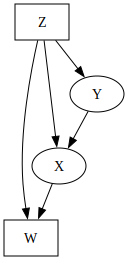

In [10]:
#| caption: Bayes net for the 4-variable model, again.
#| label: fig:bayesnet_4
show(wxyz, boxes={Z1[0], W1[0]})

Bayes’ theorem as applied above suggests an easy algorithm to calculate the posterior distribution
above: simply enumerate all tuples $\mathcal{X}$ in a table, evaluate
$P(\mathcal{X}, \mathcal{Z}=\mathfrak{z})$ for each one, and then
normalize. Note we need *only* enumerate the variables in $\mathcal{X}$, as all variables in $\mathcal{Z}$ are fixed. 

Applying this to our example entails evaluating 100 probabilities, if we assume as before that each variable can take on 10 different outcomes. We show the resulting table for the case that $\mathfrak{z}=(2, 7)$, i.e., every entry in the table is a value for $P(X, Y|W=2, Z=7)\propto P(W=2, X, Y, Z=7)$. Below we show the factorized joint probability, to make a point:

|    *x*   |    *y*   |                 *P(W=2, X=x, Y=y, Z=7)*                |
|:--------:|:--------:|:---------------------------------------------------:|
|     1    |     1    |*P(W=2\|X=1, Z=7)P(X=1\|Y=1, Z=7)P(Y=1\|Z=7)P(Z=7)*   |
|     1    |     2    |    *P(W=2\|X=1, Z=7)P(X=1\|Y=2, Z=7)P(Y=2\|Z=7)P(Z=7)*   |
| $\vdots$ | $\vdots$ |                       $\vdots$                      |
|    10    |     9    |   *P(W=2\|X=10, Z=7)P(X=10\|Y=9, Z=7)P(Y=9\|Z=7)P(Z=7)*  |
|    10    |    10    | *P(W=2\|X=10, Z=7)P(X=10\|Y=10, Z=7)P(Y=10\|Z=7)P(Z=7)* |

We normalize by calculating $\sum_{x, y} P(W=2, X=x, Y=y, Z=7)$ by summing over all these entries, and subsequently dividing all entries by the sum.

Estimating the full posterior using this approach is, obviously, *not* efficient. 
In this example the table contains 100 entries, and in
general the number of entries is *exponential* in the size of
$\mathcal{X}$. 
However, when inspecting the entries in the table
there are already some obvious ways to save: for example, $P(Z=7)$ is a
common factor in all entries, so clearly we need not bother
multiplying it in. Below we will discuss methods to fully
exploit the structure of the Bayes net to perform efficient inference.

### Exercises

1. Think more deeply about which other factors are repeatedly (and redundantly) calculated, and how you might organize the computation to avoid this.

2. Show that in the example above, if we instead condition on known values for $\mathcal{Z}=(X,Z)$, the posterior $P(W,Z|X,Y)$ factors, and as a consequence we need only enumerate two tables of length 10, instead of a large table of size 100.

```{index} Robot localization, nuisance variables
```
### Maximum a Posteriori Estimation

> MAP saves a bit on compute, but is still expensive when done naively.

For the purpose of decision making,
it is often the case that we do not require the full posterior distribution.
In these cases, we could rely on methods introduced in Section 2.4, 
such as Maximum Likelihood Estimation (MLE)
or Maximum a posteriori (MAP) estimation.
Here, we consider MAP estimation.

Suppose we are given the values
$\mathfrak{z}$ for $\mathcal{Z}$.
The MAP estimate of the
joint assignment to the other variables $\mathcal{X}$ is given by
\begin{equation}
x^*_{MAP} = \arg \max_x P(\mathcal{X}|\mathcal{Z}=\mathfrak{z}).
\end{equation}
For example, given
$\mathfrak{z}=(2, 7)$, the MAP estimate for $\mathcal{X}$ could be $x^*=3$ and
$y^*=6$. Note that to compute the MAP estimate, we need not bother with
normalizing: we can simply find the maximum entry in a table of *unnormalized*
posterior values.

**Robot localization** is a capability for autonomous mobile robots that can be achieved via MAP estimation.
For example, using the "robot" dynamic Bayes net example from the last section, let us
assume that we are given the value of all observations and actions.
Then the MAP estimate would simply be a trajectory of robot states. 
Hence, if we had an efficient way to do inference, a MAP estimate would be a
great way to estimate the trajectory of a robot over time, i.e., robot localization.

We can extend the idea of MAP to estimate only a subset of the unknown variables.
This can be useful when there are unknown variables that are not relevant
for the decision at hand.
We will refer to these unknown and irrelevant variables as **nuisance variables**.
In this case, we partition the variables into three sets:
the variables of interest $\mathcal{X}$, 
the nuisance variables $\mathcal{Y}$, and the observed variables
$\mathcal{Z}$.
Now, the posterior $P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$
can be determined by marginalizing (Section 2.4.7) over
the nuisance variables:
\begin{equation}
P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})=\sum_{\mathfrak{y}}P(\mathcal{X}, \mathcal{Y}=\mathfrak{y}|\mathcal{Z}=\mathfrak{z})\propto\sum_{\mathfrak{y}}P(\mathcal{X}, \mathcal{Y}=\mathfrak{y}, \mathcal{Z}=\mathfrak{z}).
\end{equation}
This approach to dealing with nuisance variables
increases the computational cost of finding the MAP estimate.
In addition to enumerating all possible combinations of $\mathcal{X}$ and
$\mathcal{Y}$ values, we now need to calculate
a possibly large number of sums, each exponential in the size of
$\mathcal{Y}$. In addition, the *number* of sums is
exponential in the size of $\mathcal{X}$. Below we will see that
while we can still exploit the Bayes net structure, 
this computation can still be quite expensive.

### Exercises

1.  Calculate the size of the table needed to enumerate the posterior
    over the states $X$ for the robot dynamic Bayes net from the previous section,
    given the value of all observations $Z$ and actions $A$.

2.  Show that if we are given the states, inferring the actions is
    actually quite efficient, even with the brute force enumeration.
    Hint: this is similar to the first exercise above.

```{index} pair: hidden Markov model; HMM
```
## Hidden Markov Models

> HMMs provide a general framework for perception over time.

In the previous section we discussed dynamic Bayesian networks to model how a robot state evolves over time by taking actions, and how measurements correlate to a particular state. In this section we will ask *how we can recover the state of the robot given only the observations*, i.e. without knowing the states: the state is "hidden". Here we will consider a general framework to answer this question.

A **hidden Markov model** or **HMM** is a dynamic Bayes net that has two
types of variables: states $\mathcal{X}$ and measurements $\mathcal{Z}$.
The states $\mathcal{X}$ are connected sequentially and satisfy the Markov property: 
the probability of a state $X_k$ is
only dependent on the value of the previous state $X_{k-1}$.
As we saw before, we call a sequence of random variables with this property a Markov chain. 
In addition, in an HMM we refer to the states $\mathcal{X}$ as *hidden*
states, as typically we cannot directly observe their values. Instead, 
they are indirectly observed through the measurements $\mathcal{Z}$, 
where we have one measurement per hidden state. When these two
properties are satisfied, we call this probabilistic model a hidden
Markov model.

<figure id="fig:unrolledHMM"> 
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/hmm-v2.png?raw=1" style="width:14cm" alt="">
<figcaption>An HMM for three time steps, represented as a Bayes net.</figcaption>
</figure>

Figure [2](#fig:unrolledHMM) shows an example of an HMM for three time steps, i.e., 
$\mathcal{X}=\{X_1, X_2, X_3\}$ and
$\mathcal{Z}=\{Z_1, Z_2, Z_3\}$. As discussed above, in a Bayes net
each node is associated with a conditional distribution: the Markov
chain has the prior $P(X_1)$ and transition probabilities
$P(X_2|X_1)$ and $P(X_3|X_2)$, whereas the measurements $Z_k$
depend only on the state $X_k$, modeled by measurement models
$P(Z_k|X_k)$. In other words, the Bayes net associated with this HMM encodes the following
joint distribution $P(\mathcal{X}, \mathcal{Z})$:
\begin{equation}
P(\mathcal{X}, \mathcal{Z})=P(X_1)P(Z_1|X_1)P(X_2|X_1)P(Z_2|X_2)P(X_3|X_2)P(Z_3|X_3)
\end{equation}

Note that we can also write this more succinctly as
\begin{equation}
P(\mathcal{X}, \mathcal{Z})=P(\mathcal{Z}|\mathcal{X})P(\mathcal{X})
\end{equation}
where
\begin{equation}
P(\mathcal{X})=P(X_1, X_2, X_3)=P(X_1)P(X_2|X_1)P(X_3|X_2)
\end{equation}
is the prior over state *trajectories*, and the measurement probability distribution for a given trajectory is given by
\begin{equation}
P(\mathcal{Z}|\mathcal{X})=P(Z_1|X_1)P(Z_2|X_2)P(Z_3|X_3).
\end{equation}

### Example: An HMM Describing a Robot

Let us recreate the dynamic Bayes net from the previous section here, with 3 time steps. However, we now also add conditionals on the three measurements $Z_1$, $Z_2$, and $Z_3$:

In [11]:
X[1]

(6341068275337658369, 5)

In [12]:
dbn = gtsam.DiscreteBayesNet()
dbn.add(X[1], [], "2/2/3/1/2")  # P(X1)
dbn.add(X[2], [X[1]], "2/2/2/2/2 2/2/2/2/2 2/2/2/2/2 2/2/2/2/2 2/2/200/2/2")  # P(X2)


In [13]:
dbn

DiscreteBayesNet
 
size: 2
conditional 0:  P( X1 ):
 Choice(X1) 
 0 Leaf  0.2
 1 Leaf  0.2
 2 Leaf  0.3
 3 Leaf  0.1
 4 Leaf  0.2

conditional 1:  P( X2 | X1 ):
 Choice(X2) 
 0 Choice(X1) 
 0 0 Leaf  0.2
 0 1 Leaf  0.2
 0 2 Leaf  0.2
 0 3 Leaf  0.2
 0 4 Leaf 0.0096153846
 1 Choice(X1) 
 1 0 Leaf  0.2
 1 1 Leaf  0.2
 1 2 Leaf  0.2
 1 3 Leaf  0.2
 1 4 Leaf 0.0096153846
 2 Choice(X1) 
 2 0 Leaf  0.2
 2 1 Leaf  0.2
 2 2 Leaf  0.2
 2 3 Leaf  0.2
 2 4 Leaf 0.96153846
 3 Choice(X1) 
 3 0 Leaf  0.2
 3 1 Leaf  0.2
 3 2 Leaf  0.2
 3 3 Leaf  0.2
 3 4 Leaf 0.0096153846
 4 Choice(X1) 
 4 0 Leaf  0.2
 4 1 Leaf  0.2
 4 2 Leaf  0.2
 4 3 Leaf  0.2
 4 4 Leaf 0.0096153846

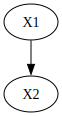

In [14]:
show(dbn)

In [15]:
print(vacuum.action_spec)


    1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
    8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 0/2/0/0/8
    0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
    0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
    0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1
    


In [16]:
help(dbn.add)

Help on method add in module gtsam.gtsam:

add(...) method of gtsam.gtsam.DiscreteBayesNet instance
    add(*args, **kwargs)
    Overloaded function.

    1. add(self: gtsam.gtsam.DiscreteBayesNet, s: gtsam.gtsam.DiscreteConditional) -> None

    2. add(self: gtsam.gtsam.DiscreteBayesNet, key: tuple[int, int], spec: str) -> None

    3. add(self: gtsam.gtsam.DiscreteBayesNet, key: tuple[int, int], parents: gtsam.gtsam.DiscreteKeys, spec: str) -> None

    4. add(self: gtsam.gtsam.DiscreteBayesNet, key: tuple[int, int], parents: list[tuple[int, int]], spec: str) -> None



In [17]:
dbn = gtsam.DiscreteBayesNet()
for k in range(1, N+1):
    dbn.add(Z[k], [X[k]], vacuum.sensor_spec)
for k in reversed(range(1, N)):
    dbn.add(X[k+1], [X[k], A[k]], vacuum.action_spec)
dbn.add(X[1], "1/1/1/1/1")

{raw:tex}`\noindent`
We "show" the resulting DBN in Figure [3.23](#fig:hmm_vacuum). Note that we display the measurement variables as boxes, as they are *given*. The only variables that are unknown or *hidden* are the three robots states $X_1$, $X_2$, and $X_3$.

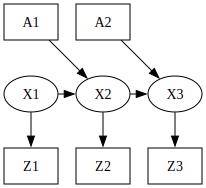

In [18]:
#| caption: A hidden Markov model.
#| label: fig:hmm_vacuum
show(dbn, hints={"A": 2, "X": 1, "Z": 0}, boxes={A[k][0] for k in range(1, N)}.union({Z[k][0] for k in range(1, N+1)}))

In [19]:
dbn

X1,0,1,2
0,0.1,0.1,0.8
1,0.1,0.1,0.8
2,0.2,0.7,0.1
3,0.8,0.1,0.1
4,0.1,0.8,0.1
X2,0,1,2
0,0.1,0.1,0.8
1,0.1,0.1,0.8
2,0.2,0.7,0.1
3,0.8,0.1,0.1


In [20]:
# Let's state actions and sensing:
actions = VARIABLES.assignment({A[1]: 'R', A[2]: 'U'})
measurements = ['dark', 'medium', 'light']

In [21]:
# Let's iterate over states:
for x1 in vacuum.rooms:
    for x2 in vacuum.rooms:
        for x3 in vacuum.rooms:
          print(x1,x2,x3)

Living Room Living Room Living Room
Living Room Living Room Kitchen
Living Room Living Room Office
Living Room Living Room Hallway
Living Room Living Room Dining Room
Living Room Kitchen Living Room
Living Room Kitchen Kitchen
Living Room Kitchen Office
Living Room Kitchen Hallway
Living Room Kitchen Dining Room
Living Room Office Living Room
Living Room Office Kitchen
Living Room Office Office
Living Room Office Hallway
Living Room Office Dining Room
Living Room Hallway Living Room
Living Room Hallway Kitchen
Living Room Hallway Office
Living Room Hallway Hallway
Living Room Hallway Dining Room
Living Room Dining Room Living Room
Living Room Dining Room Kitchen
Living Room Dining Room Office
Living Room Dining Room Hallway
Living Room Dining Room Dining Room
Kitchen Living Room Living Room
Kitchen Living Room Kitchen
Kitchen Living Room Office
Kitchen Living Room Hallway
Kitchen Living Room Dining Room
Kitchen Kitchen Living Room
Kitchen Kitchen Kitchen
Kitchen Kitchen Office
Kitchen 

In [23]:
# Does not work with strange error, because DBN needs values for all variables!
# So let's create a DiscreteValues object with all actions and measurements:
known = {A[1]: 'R', A[2]: 'U', Z[1]: 'dark', Z[2]: 'medium', Z[3]: 'light'}

In [24]:
# Let's iterate over states and create trajectory values
trajectory = {}
for x1 in vacuum.rooms:
    trajectory[X[1]] = x1
    for x2 in vacuum.rooms:
        trajectory[X[2]] = x2
        for x3 in vacuum.rooms:
            trajectory[X[3]] = x3
            values = VARIABLES.assignment(known | trajectory)
            p = dbn.evaluate(values)
            if (p > 1e-6):
              print(f"{x1[0]}{x2[0]}{x3[0]}:\t{100*p:.2f}%")

LLL:	0.03%
LKK:	0.13%
KKK:	0.16%
OOO:	0.06%
OHL:	0.20%
OHH:	0.01%
HHL:	0.20%
HHH:	0.01%
HDK:	6.55%
HDD:	0.20%
DDK:	1.02%
DDD:	0.03%


In [25]:
# So: MPE:
# iterate over states and create trajectory values and pick max
max_p = 0
trajectory = {}
max_trajectory = {}
for x1 in vacuum.rooms:
    trajectory[X[1]] = x1
    for x2 in vacuum.rooms:
        trajectory[X[2]] = x2
        for x3 in vacuum.rooms:
            trajectory[X[3]] = x3
            values = VARIABLES.assignment(known | trajectory)
            p = dbn.evaluate(values)
            if (p > 1e-6):
              print(f"{x1[0]}{x2[0]}{x3[0]}:\t{100*p:.2f}")
              if p > max_p:
                  max_p = p
                  max_trajectory = trajectory.copy()
print(f"Maximum a posteriori estimate (MPE), with p={100*max_p:.2f}:")
pretty(VARIABLES.assignment(max_trajectory))

LLL:	0.03
LKK:	0.13
KKK:	0.16
OOO:	0.06
OHL:	0.20
OHH:	0.01
HHL:	0.20
HHH:	0.01
HDK:	6.55
HDD:	0.20
DDK:	1.02
DDD:	0.03
Maximum a posteriori estimate (MPE), with p=6.55:


Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


```{index} likelihood
```
## Naive Inference in HMMs

> Inference is easy to implement naively, but hopelessly inefficient.

As we saw above,
one way to perform inference is to apply Bayes’ theorem to obtain an expression for the posterior probability distribution over
the state trajectory $\mathcal{X}$, given the measurements
$\mathcal{Z}=\mathfrak{z}$:
\begin{equation}\begin{aligned}
P(\mathcal{X}|\mathcal{Z}) & \propto P(\mathcal{Z}=\mathfrak{z}|\mathcal{X})P(\mathcal{X}) \\
& =L(\mathcal{X}; \mathcal{Z}=\mathfrak{z})P(\mathcal{X})
\end{aligned}\end{equation}
where $P(\mathcal{X})$ is the trajectory prior
and the likelihood $L(\mathcal{X}; \mathcal{Z}=\mathfrak{z})$ of
$\mathcal{X}$ given $\mathcal{Z}=\mathfrak{z}$ is defined as before as a function of $\mathcal{X}$: 
\begin{equation}\begin{aligned}
L(\mathcal{X}; \mathcal{Z}=\mathfrak{z}) & \propto P(\mathcal{Z}=\mathfrak{z}|\mathcal{X})\\
& =P(z_1|X_1)P(z_2|X_2)P(z_3|X_3)\\
& \propto L(X_1; Z_1)L(X_2; Z_2)L(X_3; Z_3)
\end{aligned}\end{equation}

Hence, a naive implementation for finding the MAP estimate
for $\mathcal{X}$ would tabulate all possible
trajectories $\mathcal{X}$ and calculate the posterior $P(\mathcal{X}|\mathcal{Z})$ for each one. 
Unfortunately the number of entries in this giant table is
*exponential* in the number of states. Not only is this computationally
prohibitive for long trajectories, but intuitively it is clear that for
many of these trajectories we are computing the same values over and
over again. There are three different approaches to improve on
this:

1.  Branch & bound

2.  Dynamic programming

3.  Inference using factor graphs

Branch and bound is a powerful technique but will not generalize to
continuous variables; the other two approaches will. And, we will
see that dynamic programming in HMMs, which underlies the classical inference
algorithms in the HMM literature, is a special case of the last
approach. Hence, here we will dive in and immediately go for the most
general approach: inference in factor graphs.

```{index} factors, unary factors, binary factors
```
## Factor Graphs

> Factor graphs are an excellent representation in which to do inference.

We first introduce the notion of factors. 
Again referring to the example from Figure [3.23](#fig:unrolledHMM)
let us consider the posterior.
Since the measurements $\mathcal{Z}$ are *known*, the posterior is
proportional to the product of six **factors**, three of which derive
from the Markov chain, and three of which are likelihood factors as defined
above:
\begin{equation}
P(\mathcal{X}|\mathcal{Z})\propto P(X_1)L(X_1; z_1)P(X_2|X_1)L(X_2; z_2)P(X_3|X_2)L(X_3; z_3)
\end{equation}
Some of these factors are **unary factors**, and some are **binary factors**, by which we mean that
some of the factors depend on just *one* hidden variable,
for example $L(X_2; z_2)$, whereas others depend on *two* variables, e.g., the transition model $P(X_3|X_2)$. 
Measurements are not counted here, 
because once we are *given* the measurements $\mathcal{Z}$, they merely
function as known parameters in the likelihoods $L(X_k; z_k)$, which
are seen as functions of *just* the state $X_k$, i.e., they will yield unary factors in the unknowns.

```{index} factor graph
```
<figure id="fig:HMM-FG">
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/fg-v2.png?raw=1" style="width:60%" alt="">
<figcaption>An HMM with observed measurements for three time steps, represented as a factor graph.</figcaption>
</figure>

This motivates a different graphical model, a **factor graph**, in which
we only represent the *hidden* variables $X_1$, $X_2$, and $X_3$, 
connected to factors that encode probabilistic information. For
our example with three hidden states, the corresponding factor graph is
shown in Figure [4](#fig:HMM-FG).
It should be clear from the figure that the connectivity of a factor
graph encodes, for each factor $\phi_{i}$, which subset of variables
$\mathcal{X}_{i}$ it depends on. We write:
\begin{equation}
\phi(\mathcal{X})=\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)\phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\end{equation}
where the factors above are defined to correspond one-to-one to the six factors in the posterior, 
e.g., 
\begin{equation}
\phi_6(X_3)\doteq L(X_3; z_3).
\end{equation}

All measurements are associated with unary factors, whereas the Markov chain is
associated mostly with binary factors, with the exception of the unary
factor $\phi_1(X_1)$. Note that in defining the factors we can omit
any normalization factors, which in many cases results in computational
savings.

```{index} factors, variables
```
Formally a factor graph is a bipartite graph
$F=(\mathcal{U}, \mathcal{V}, \mathcal{E})$ with two types of nodes:
**factors** $\phi_{i}\in\mathcal{U}$ and **variables**
*$X_{j}\in\mathcal{V}$.* Edges $e_{ij}\in\mathcal{E}$ are always between
factor nodes and variables nodes, never between variables or between factors. 
The set of random variable nodes
adjacent to a factor $\phi_{i}$ is written as $\mathcal{X}_{i}$. With
these definitions, a factor graph $F$ defines the factorization of a
global function $\phi(\mathcal{X})$ as
\begin{equation}
\phi(\mathcal{X})=\prod_{i}\phi_{i}(\mathcal{X}_{i}).
\end{equation}

In other words, the independence relationships are encoded by the edges
$e_{ij}$ of the factor graph, with each factor $\phi_{i}$ a function of
*only* the variables $\mathcal{X}_{i}$ in its adjacency set. As example, 
for the factor graph in Figure [4](#fig:HMM-FG) we have: 
\begin{equation}
\begin{aligned}
\mathcal{X}_1 & =\{X_1\}\\
\mathcal{X}_2 & =\{X_1\}\\
\mathcal{X}_3 & =\{X_1, X_2\}\\
\mathcal{X}_4 & =\{X_2\}\\
\mathcal{X}_5 & =\{X_2, X_3\}\\
\mathcal{X}_6 & =\{X_3\}
\end{aligned}
\end{equation}

## Converting Bayes Nets into Factor Graphs.

> It is trivial to convert Bayes nets into factor graphs.

<figure id="fig:conversion">
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/hmm-v2.png?raw=1" style="width:12cm" alt="">
<figcaption>Bayes net representation of an HMM.</figcaption>
</figure>

<figure id="fig:conversion-2">
<img src="https://raw.githubusercontent.com/gtbook/robotics/main/Figures3/fg-v2.png?raw=1"  style="width:14cm" alt="">
<figcaption>Conversion of HMM above to a factor graph, where measurements are known.</figcaption>
</figure>

Every Bayes net can be trivially converted to a factor graph, as shown above.
Recall that every node in a Bayes net denotes a conditional density on the
corresponding variable and its parent nodes. Hence, the conversion is
quite simple: every Bayes net node maps to *both* a variable node and
a factor node in the corresponding factor graph. The factor is connected
to the variable node, as well as the variable nodes corresponding to the
parent nodes in the Bayes net. If some nodes in the Bayes net are
evidence nodes, i.e., they are given as known variables, we omit the
corresponding variable nodes: the known variable simply becomes a fixed
parameter in the corresponding factor.

### Exercise

1.  Convert the dynamic Bayes net from the previous section into a factor graph, assuming *no* known variables.

1.  Finally, do the same again, but now assume the states are given. Reflect on the remarkable phenomenon that happens.


## Factor Graphs in GTSAM

Let us create the factor graph directly using GTSAM. Before we do, however, we need to instantiate the given actions and measurements, both of which are assumed known:


In [26]:
actions = VARIABLES.assignment({A[1]: 'R', A[2]: 'U'})
measurements = ['dark', 'medium', 'light']

Now we create the factor graph, first adding the prior $\phi(X_1)=P(X_1)$ on $X_1$, then the binary factors $\phi(X_k, X_{k+1}) = P(X_{k+1}|X_k, A_k=a_k)$,
and finally, the measurement likelihood factors $\phi(X_k; Z_k=z_k) \propto P(Z_k=z_k|X_k)$:

In [27]:
graph = gtsam.DiscreteFactorGraph()
graph.add(X[1], "1 1 1 1 1")  # \phi(X_1) = P(X_1)
for k in range(1, N):
    conditional = gtsam.DiscreteConditional(X[k + 1], [X[k], A[k]], vacuum.action_spec)
    conditional_a_k = conditional.choose(actions)  # \phi(X,X+) = P(X+|X,A=a)
    graph.push_back(conditional_a_k)
for k, measurement in enumerate(measurements, start=1):
    conditional = gtsam.DiscreteConditional(Z[k], [X[k]], vacuum.sensor_spec)
    z_k = vacuum.light_levels.index(measurement)
    factor = conditional.likelihood(z_k)  # \phi(X) = P(Z=z|X)
    graph.push_back(factor)

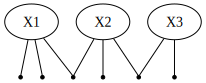

In [28]:
#| caption: A three-variable factor graph for when measurements are *given*
#| label: fig:factor_graph_vacuum
show(graph)


Note that discrete distributions like $P(X_1)$ and conditionals $P(X_{k+1}|X_k)$, above, are perfectly fine factors, and in fact *derive* from the factor type in GTSAM. This is what allows us to add them directly the graph as is. Note that in a real implementation we might not take the detour to first construct the conditionals as above: we did so because they were conveniently available here, but typically we would construct factors directly.

```{index} optimization
```
## Computing with Factor Graphs

> We can evaluate, optimize, and sample from factor graphs.

Once we convert a Bayes net with evidence into a factor graph where the
evidence is all implicit in the factors, we can support a number of
different computations. First, given any factor graph defining an
unnormalized density $\phi(X)$, we can easily *evaluate* it for any
given value, by simply evaluating every factor and multiplying the
results. The factor graph represents the unnormalized posterior, i.e., 
$\phi(\mathcal{X})\propto P(\mathcal{X}|\mathcal{Z})$. 

Evaluation opens up the way to **optimization**, e.g., finding the MAP estimate,
as we will do below. 
The naive optimization method of enumerating and 
evaluating all possible assignments for $\mathcal{X}$ is of course always available,
but just as inefficient.
In the case of discrete variables, graph search methods can be applied, but we will discuss a
different approach in the next subsection.

Because our factor graph is so small, it does not hurt to show off how easy it is to implement the naive algorithm to find the MAP estimate. We just loop over all possible state trajectories, and keep track of the one with the highest value:

In [29]:
map_value = 0
map_trajectory = None
for x1 in vacuum.rooms:
    for x2 in vacuum.rooms:
        for x3 in vacuum.rooms:
            trajectory = VARIABLES.assignment({X[1]: x1, X[2]: x2, X[3]: x3})
            value = graph(trajectory)
            if value > map_value:
                map_value = value
                map_trajectory = trajectory
print(f"found MAP solution with value {map_value:.4f}:")
pretty(map_trajectory)


found MAP solution with value 0.3277:


Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


Note that this MAP estimate is *for a given action and measurement sequence*. All those fixed values are implicit in the factors that we have added to the factor graph in `graph` above.

```{index} sampling, Gibbs sampling
```
Finally, while finding the maximum of the posterior (MAP) is often of most
interest, **sampling** from a probability distribution can be used to
visualize, explore, and compute statistics and expected values
associated with the posterior. The ancestral sampling method we
discussed earlier only applies to Bayes nets, however.
There are more general sampling algorithms that can be used for factor
graphs. 
One such method is **Gibbs sampling**, which proceeds by sampling one variable
at a time from its conditional density given all other variables it is
connected to via factors. This assumes that this conditional density can
be easily obtained, which is true for discrete variables.

## The Max-Product Algorithm for HMMs

```{index} max-product algorithm, Viterbi algorithm
```
> Max-product on HMMs, also known as the Viterbi algorithm, is a dynamic programming algorithm for finding a
MAP estimate.

In this section we discuss an algorithm that is much faster than the naive algorithm to find the MAP estimate.
Given an HMM factor graph of size $n$, the **max-product algorithm** is an $O(n)$ algorithm
to find the MAP estimate, which is used by GTSAM under the hood.

Let us use the example from Figure [4](#fig:HMM-FG) to understand the main idea behind it. To find the MAP estimate for $\mathcal{X}$ we need to
*maximize* the product
\begin{equation}
\phi(X_1, X_2, X_3)=\prod\phi_{i}(\mathcal{X}_{i})
\end{equation}
i.e., the value of the factor graph.
Because this is a product of factor values, we can compute its maximum recursively - dynamic programming style. We start by writing out the maximization over the product explicitly:
\begin{equation}
\max_{\mathcal{X}} \prod\phi_{i}(\mathcal{X}_{i}) = 
\max_{X_1, X_2, X_3} ~~~\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) \phi_4(X_2)\phi_5(X_2, X_3)\phi_6(X_3) 
\end{equation}

The key to our recursion will be to consider each variable in turn, starting with $X_1$. In particular, let us group all the factors connected to $X_1$
\begin{equation}
\max_{\mathcal{X}} \prod\phi_{i}(\mathcal{X}_{i}) = 
\max_{X_1, X_2, X_3} ~~~ \{ \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) \} ~~~ \phi_4(X_2)\phi_5(X_2, X_3)\phi_6(X_3)
\end{equation}
which allows us to move the *max* operator over $X_1$ inside:
\begin{equation}
\max_{\mathcal{X}} \prod\phi_{i}(\mathcal{X}_{i}) = 
\max_{X_2, X_3} ~~~ \{ \max_{X_1} \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) \} ~~~ \phi_4(X_2)\phi_5(X_2, X_3)\phi_6(X_3)
\end{equation}
The key to the recursion is that we can simply consider the expression inside the curly braces as new factor on $X_2$, defined as
\begin{equation}
\tau(X_2)\doteq \max_{X_1} \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2),
\end{equation}
which records the maximum value resulting from *only* maximizing $X_1$. The value of the computation depends on the value of $X_2$, because $X_2$ was involved in factor $\phi_3$. However, crucially, the variable $X_3$ is not involved in the maximization.

Substituting the new factor into the maximization, we now need to maximize over a *reduced* factor graph that no longer is a function of $X_1$,
\begin{equation}
\max_{\mathcal{X}} \prod\phi_{i}(\mathcal{X}_{i}) =
\max_{X_2, X_3} ~~~\tau(X_2) \phi_4(X_2)\phi_5(X_2, X_3)\phi_6(X_3)
\end{equation}
and this allows us to recurse until no more variables are left!

```{index} Viterbi algorithm, elimination algorithm
```
For hidden Markov models this dynamic programming approach is known as the **Viterbi Algorithm**. Note that the algorithmic sketch above only yields the *value* of the factor graph at the maximum. A key part of the Viterbi algorithm is adding some bookkeeping, so that after the recursion terminates, we can recover the actual variable assignments that make the factor graph attain its maximum value.
Also, the complexity of max-product for HMMs is *linear* in the number of nodes, which is a nice improvement over exponential complexity. The complexity of every elimination step is quadratic in the number of states, because we have to form the product factors and then maximize over them.

Because at every step, one variable is eliminated from the maximization, the max-product algorithm is in fact an instance of the **elimination algorithm**, which works for *arbitrary* factor graphs, albeit not necessarily in $O(n)$ time. Indeed, the max-product (and sum-product below) can be applied in more general settings than the linear chains one finds in HMMs. While we won't discuss this connection in more detail here, the elimination algorithm pops up in many other contexts, and is worth a book in its own right.

### Max-product in GTSAM

GTSAM's bread and butter is factor graphs, and finding the MAP value is done via a single `optimize` call, which implements the max-product algorithm internally, bookkeeping and all:


In [30]:
map_value = graph.optimize()
pretty(map_value)

Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


The resulting `DiscreteValues` instance corresponds to the MAP trajectory given the actions and measurements at every step. And, of course, this generalizes to much larger sequences, scaling only linearly in complexity with the number of time steps.

## The Sum-Product Algorithm for HMMs

```{index} sum-product algorithm
```

> Sum-product on HMMs is a dynamic programming algorithm for doing full posterior inference.

The **sum-product** algorithm for HMMs is a slight tweak on the max-product
algorithm that instead calculates the posterior probability $P(\mathcal{X}|\mathcal{Z})$. 
Whereas the max-product results in a single variable assignment, the sum-product produces a Bayes net that represents the *full Bayesian probability distribution*.
The fact that we recover this distribution in the form of a Bayes net again is
satisfying, because, as we have seen, that is an economical representation of a
probability distribution.

One might wonder about the wisdom of all this: we started with a Bayes
net, converted to a factor graph, and now end up with a Bayes net again?
There are two important differences. 
First, in many practical cases we do not even bother with the modeling step, but
construct the factor graph directly from the measurements.
Second, even if we did, this first Bayes represents the joint 
distribution $P(\mathcal{X}, \mathcal{Z})$, useful for modeling and simulation.
However, the second, "posterior Bayes net" represents just $P(\mathcal{X}|\mathcal{Z})$, and only has nodes for the random variables in $\mathcal{X}$ and is only half the size. Below we show how to compute it.

Again, the key is that we can compute the posterior recursively from the product of factors, in dynamic programming style.
For the example above, this gives
\begin{equation}
\begin{aligned}
P(\mathcal{X}|\mathcal{Z}) &\propto \prod\phi_{i}(\mathcal{X}_{i})
\\&\propto \phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) \phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\\&\propto \{\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2)\} ~~ \phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)
\end{aligned}
\end{equation}
where we once again grouped the factors connected to $X_1$ inside the curly braces.
Using the chain rule, we can express those as the product of a conditional (which will end up in the Bayes net) and a new factor $\tau(X_2)$:
\begin{equation}
\phi_1(X_1)\phi_2(X_1)\phi_3(X_1, X_2) = P(X_1|X_2, \mathcal{Z}) \tau(X_2).
\end{equation}
Note that above we explicitly indicate the dependence on $\mathcal{Z}$ in $P(X_1|X_2, \mathcal{Z})$, which was left implicit in the factor graph. Substituting this back in, we get a conditional multiplied with a smaller factor graph that no longer involves $X_1$, and we can recurse:
\begin{equation}
\begin{aligned}
P(\mathcal{X}|\mathcal{Z}) &\propto P(X_1|X_2, \mathcal{Z}) ~~ \{ \tau(X_2) \phi_4(X_2)\phi_5(X_2, X_{3})\phi_6(X_3)\}
\\ &\propto P(X_1|X_2, \mathcal{Z}) P(X_2 | X_{3}, \mathcal{Z}) ~~ \{\tau(X_{3})\phi_6(X_3)\}
\\ &\propto P(X_1|X_2, \mathcal{Z}) P(X_2 | X_{3}, \mathcal{Z}) P(X_3| \mathcal{Z}).
\end{aligned}
\end{equation}
Each of the three conditionals above was computed by implementing the chain rule, which is a simple calculation in the case of discrete factors.

## Sum-Product in GTSAM

In GTSAM, once again the sum-product is but a simple call to the `sumProduct` method of a factor graph. It yields a `DiscreteBayes` net which encodes the full posterior distribution:

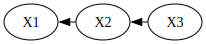

In [31]:
#| caption: The full posterior encoded as a Bayes net.
#| label: fig:posterior_bn
posterior = graph.sumProduct()
show(posterior, hints={"X": 1})


One of the things we can do with this *exact* posterior is sample from it, which generates one possible state history conditioned on the available sensor measurements *and* the known action sequence:

In [32]:
sample = posterior.sample()
pretty(sample)


Variable,value
X1,Hallway
X2,Dining Room
X3,Kitchen


## Sampling and Posterior Means*

> Bayesian reasoning at its best.

When we can produce samples $\mathcal{X}^{(s)}$ from a posterior
$P(\mathcal{X}|\mathcal{Z})$, we can calculate the empirical mean of any
real-valued function $f(\mathcal{X})$ as follows,
\begin{equation}
E_{P(\mathcal{X}|\mathcal{Z})}[f(x)]\approx \frac{1}{N}\sum f(\mathcal{X}^{(s)}),
\end{equation}
where $N$ is the number of samples.
For example, we can calculate the posterior mean of how far the robot
traveled, either in Euclidean or Manhattan distance, using this approach. 
Doing this will provide a more reliable estimate than merely 
calculating the distance for the MAP value,
since this approach averages over the entire probability distribution rather
than just using a single (albeit most probable) estimate.


For example, the code below samples 1000 alternate state histories, parallel universes of what *could* have happened: 

In [33]:
counts = np.zeros((3, 5))
num_samples = 1000
for i in range(num_samples):
    sample = posterior.sample()
    for k in range(1,3+1):
        key = X[k][0]
        room_index = sample[key]
        counts[k-1][room_index] += 1 # base 0!

In [34]:
counts

array([[ 14.,  15.,  20., 831., 120.],
       [  4.,  25.,   8.,  41., 922.],
       [ 44., 926.,   8.,   1.,  21.]])

Posterior means give us a way to summarize these 1000 alternate histories some way other than just printing them all out. One idea is to summarize, for every time step, what the probability is to be in a particular room. It turns out we can do this with a one-liner, because we kept track of counts in the code above:

In [35]:
pd.DataFrame(data=100*counts/num_samples,
             index=range(1, N+1), columns=vacuum.rooms)

,Living Room,Kitchen,Office,Hallway,Dining Room
1,1.4,1.5,2.0,83.1,12.0
2,0.4,2.5,0.8,4.1,92.2
3,4.4,92.6,0.8,0.1,2.1


These approximate marginals say how probable it is that the robot was in a particular room at a particular time step. This is much richer information that what is available in the MAP value, which is just a point estimate for the trajectory. 

### Exercise

Execute the code above multiple times and observe that you *do* get different realizations (almost) every time, but that the approximate marginals stay roughly the same.

## GTSAM 101

> The GTSAM concepts used in this section, explained.

We created, for the first time, an instance of the `DiscreteFactorGraph` class. The constructor is trivial - takes no arguments.
To add factors, we can use the following methods:

 1. `add(self, j: Tuple[int, int], spec: str) -> None`

 2. `add(self, j: Tuple[int, int], spec: List[float]) -> None`

 3. `add(self, keys: List[Tuple[int, int]], spec: str) -> None`

{raw:tex}`\noindent`
These are very similar to the `DiscreteBayesNet` methods, but in factor graphs there is a
distinction between frontal and parent values, so we just have a key, or a list of keys as in the last method.

Two key factor graph methods we used above are `optimize` and `sumProduct`:

```python
- optimize(self) -> gtsam::DiscreteValues
- sumProduct(self) -> gtsam.DiscreteBayesNet
```

{raw:tex}`\noindent`
The first one returns the MAP value as an assignment to discrete variables, whereas the second returns an entire Bayes net, encoding the posterior.